# Overfitting - Part 2

In this lesson you are going to learn about ***Drop Out*** and how it helps the problem of overfitting. 

> What is Drop Out? 

This is a technique that will help your model generalize and prevent overfitting. So how does it work? Well, all you are going to do is while training, you are going to literally ***shoot down*** a percentage of your Neurons. On every iteration you are going to shoot down ***at random*** a percentage of your neurons. This will prevent your model from getting too cozy with your data and ultimately help you overcome any overfitting issues.  

Keep reading and you will see how easy it is to implement this technique.

**核心思想**：随机的打开或关闭一些中间节点。

# Let's Get to Work!

In [1]:
# import libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import sys
import datetime
import matplotlib.pyplot as plt
plt.style.use('ggplot') # use this plot style
%matplotlib inline

print('Python version ' + sys.version)
print('Tensorflow version ' + tf.VERSION)
print('Pandas version ' + pd.__version__)
print('Numpy version ' + np.__version__)

Python version 3.6.3 |Anaconda, Inc.| (default, Nov  3 2017, 12:34:11) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
Tensorflow version 1.1.0
Pandas version 0.20.3
Numpy version 1.12.1


# Function to model

    y = a * x^4 + b  


> TIP: Recommended percentages  

* Training - ***70%***
* Validation - ***15%***
* Test - ***15%***

In [2]:
pool = np.random.rand(1000,1).astype(np.float32)

np.random.shuffle(pool)

sample = int(1000 * 0.15)

test_x = pool[0:sample]
valid_x = pool[sample:2*sample]
train_x = pool[2*sample:]

print('test_x shape:',test_x.shape)
print('valid_x shape:',valid_x.shape)
print('train_x shape:',train_x.shape)

# f = lambda x: 2.0 * x**4 + 5
# test_y = f(test_x)
# valid_y = f(valid_x)
# train_y = f(train_x)

test_y = 2.0 * test_x**4 + 5
valid_y = 2.0 * valid_x**4 + 5
train_y = 2.0 * train_x**4 + 5

test_x shape: (150, 1)
valid_x shape: (150, 1)
train_x shape: (700, 1)


In [3]:
df = pd.DataFrame({'x':train_x[:,0],'y':train_y[:,0]})
df.head()

,x,y
0,0.113946,5.000337
1,0.253260,5.008228
2,0.685539,5.441733
3,0.533656,5.162209
4,0.689360,5.451662


In [4]:
df.describe()

,x,y
count,700.000000,700.000000
mean,0.498271,5.399415
std,0.290264,0.535967
min,0.001613,5.000000
25%,0.249368,5.007734
50%,0.511677,5.137100
75%,0.745140,5.616572
max,0.999887,6.999094


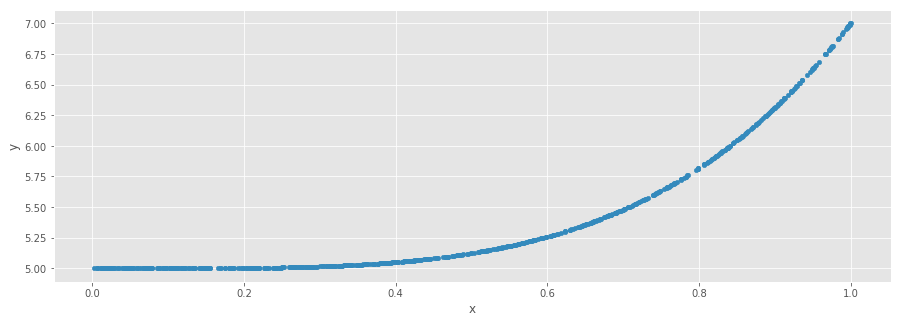

In [5]:
df.plot.scatter(x='x',y='y',figsize=(15,5))

# Helper Functions  

Make a function that will help you create layers easily

In [6]:
def add_layer(inputs, in_size, out_size, activation_function=None):
    
    # tf.random_normal([what is the size of your batches, size of output layer])
    Weights = tf.Variable(tf.truncated_normal([in_size, out_size], mean=0.1, stddev=0.1))
    
    # tf.random_normal([size of output layer])
    biases = tf.Variable(tf.truncated_normal([out_size], mean=0.1, stddev=0.1))
    
    # shape of pred = [size of your batches, size of output layer]
    pred = tf.matmul(inputs, Weights) + biases

    if activation_function is None:
        outputs = pred
    else:
        outputs = activation_function(pred)
    return outputs

# Model your Graph

Start to use W (for weight) and b (for bias) when setting up your variables. Aside from adding your ReLU activation function, it is a good idea to use Tensorflow's ***matrix multiplication function (matmul)*** as shown below.  

> The ? in the shape output just means it can be of any shape.

For the shape parameter, you can think of it like this...  

> shape = [how many data points do you have, how many features does each data point have]  

For this lesson since we are doing a simple regression, we only have one feature (x). We use the ***None*** keyword so that we are not restricted on the number of samples to feed our model. This will become more important when you learn about training using batches on a future lesson.

In [7]:
hidden_size = 10

x = tf.placeholder(tf.float32,shape=[None,1],name='01_x')
y = tf.placeholder(tf.float32,shape=[None,1],name='01_y')

print(x.get_shape())
print(y.get_shape())

(?, 1)
(?, 1)


# Add Your Drop Out Placeholder  

We will be feeding in the percentage of neurons to keep on every epoch

In [8]:
# drop put
keep_prob = tf.placeholder(tf.float32)

Note that the input of one layer becomes the input of the next layer.

In [9]:
h1 = add_layer(x, 1, hidden_size, tf.nn.relu)
h1_drop = tf.nn.dropout(h1,keep_prob)

h2 = add_layer(h1_drop, hidden_size, hidden_size, tf.nn.relu)
h2_drop = tf.nn.dropout(h2,keep_prob)

h3 = add_layer(h2_drop, hidden_size, hidden_size, tf.nn.relu)
h3_drop = tf.nn.dropout(h3,keep_prob)

h4 = add_layer(h3_drop, hidden_size, hidden_size, tf.nn.relu)
h4_drop = tf.nn.dropout(h4,keep_prob)

print("shape of hidden layers:")
print(h1_drop.get_shape(),h2_drop.get_shape(),h3_drop.get_shape(),h4_drop.get_shape())

shape of hidden layers:
(?, 10) (?, 10) (?, 10) (?, 10)


In [10]:
# output layer
pred = add_layer(h4_drop,hidden_size,1)

print("shape of output layer:")
print(pred.get_shape())

shape of output layer:
(?, 1)


In [11]:
# minimize the mean square error
loss = tf.reduce_mean(tf.square(pred - y))

optimizer = tf.train.GradientDescentOptimizer(0.01)
train = optimizer.minimize(loss)

# How Good is Your model?  

Set up the following variables to calculate the accuracy rate of your model. You will do that shortly.

In [12]:
correct_prediction = tf.equal(tf.round(pred),tf.round(y))
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

# Set Up Your Early Stoppage Variables  

Code borrowed from this great [Tensorflow Jupyter Notebook](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/04_Save_Restore.ipynb).

In [13]:
# Best validation accuracy seen so far.
best_valid_acc = 0.0

# Iteration-number for last improvement to validation accuracy.
last_improvement = 0

# Stop optimization if no improvement found in this many iterations.
require_improvement = 1500

# Training Time!  

Notice how we pass in our Drop Out percentage below.

* ***keep_prob of 1.0*** means we are not going to shoot down any of our neurons. This is handy since we would not want to do this to our Validation or Test sets.
* ***测试集和验证集的keep_prob设为1.0*** 

In [17]:
# Best validation accuracy seen so far.
best_valid_acc = 0.0

# Iteration-number for last improvement to validation accuracy.
last_improvement = 0

# Stop optimization if no improvement found in this many iterations.
require_improvement = 1500

init = tf.global_variables_initializer()

t = []

with tf.Session() as sess:
    
    sess.run(init)
    
    train_data = {x:train_x,y:train_y,keep_prob:0.975}
    valid_data = {x:valid_x,y:valid_y,keep_prob:1.0}
    test_data = {x:test_x,y:test_y,keep_prob:1.0}
    
    for step in range(6000):
        
        train_loss,train_pred = sess.run([loss,train],feed_dict=train_data)
        
        if step % 100 == 0:
            
            train_acc = accuracy.eval(train_data)
            valid_acc = accuracy.eval(valid_data)
            
            valid_loss = loss.eval(valid_data)
            
            t.append([step,train_loss,valid_loss])
            
            if valid_acc > best_valid_acc:
                best_valid_acc = valid_acc
                last_improvement = step
                improve_str = '*'
            else:
                improve_str = ''
            
            print("step %d,train_acc:%f,valid_acc:%f,train_loss:%f,valid_loss:%f %s" % (step,train_acc,valid_acc,train_loss,valid_loss,improve_str)) 
            
            if step - last_improvement > require_improvement:
                print('No more improve!')
                print("step %d,train_acc:%f,valid_acc:%f,train_loss:%f,valid_loss:%f %s" % (step,train_acc,valid_acc,train_loss,valid_loss,improve_str))
                break
            
    print('train accuracy:',accuracy.eval(train_data))
    print('valid accuracy:',accuracy.eval(valid_data))
    print('test accuracy:',accuracy.eval(test_data))
    
    test_results = sess.run(pred,feed_dict={x:test_x,keep_prob:1.0})
    df_final = pd.DataFrame({'test_x':test_x[:,0],'pred':test_results[:,0]})
    df_loss = pd.DataFrame(t,columns=['step','train_loss','valid_loss'])

step 0,train_acc:0.000000,valid_acc:0.000000,train_loss:27.195681,valid_loss:24.367844 
step 100,train_acc:0.658571,valid_acc:0.760000,train_loss:0.243675,valid_loss:0.077451 *
step 200,train_acc:0.652857,valid_acc:0.766667,train_loss:0.219378,valid_loss:0.075859 *
step 300,train_acc:0.662857,valid_acc:0.773333,train_loss:0.196028,valid_loss:0.075269 *
step 400,train_acc:0.695714,valid_acc:0.760000,train_loss:0.198223,valid_loss:0.074964 
step 500,train_acc:0.682857,valid_acc:0.766667,train_loss:0.176915,valid_loss:0.074697 
step 600,train_acc:0.691429,valid_acc:0.753333,train_loss:0.207451,valid_loss:0.075212 
step 700,train_acc:0.700000,valid_acc:0.760000,train_loss:0.170228,valid_loss:0.074155 
step 800,train_acc:0.684286,valid_acc:0.766667,train_loss:0.161315,valid_loss:0.073191 
step 900,train_acc:0.720000,valid_acc:0.753333,train_loss:0.163763,valid_loss:0.067646 
step 1000,train_acc:0.714286,valid_acc:0.780000,train_loss:0.140251,valid_loss:0.062385 *
step 1100,train_acc:0.72571

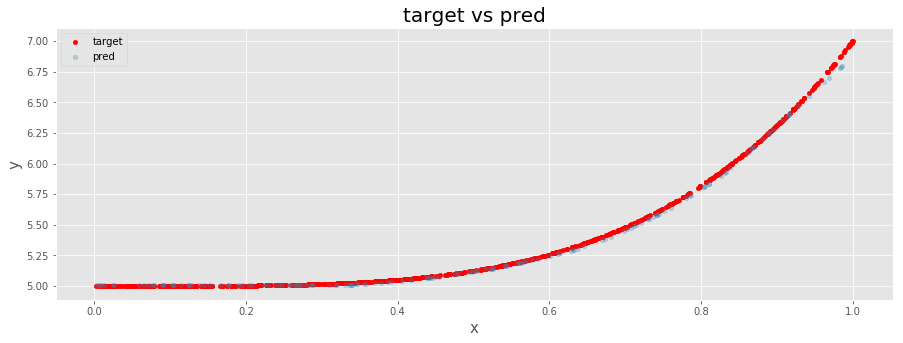

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

# Chart 1 - Shows the line we are trying to model
df.plot.scatter(x='x', y='y', ax=axes, color='red')

# Chart 2 - Shows the line our trained model came up with
df_final.plot.scatter(x='test_x', y='pred', ax=axes, alpha=0.3)

# add a little sugar
axes.set_title('target vs pred', fontsize=20)
axes.set_ylabel('y', fontsize=15)
axes.set_xlabel('x', fontsize=15)
axes.legend(["target", "pred"], loc='best'); 

# Check for Overfitting  

If the ***valid_loss*** is increasing and your ***train_loss*** is decreasing then you have a problem. Since you have implemented early stopping, your model will not over train and prevents this issue from getting out of control.

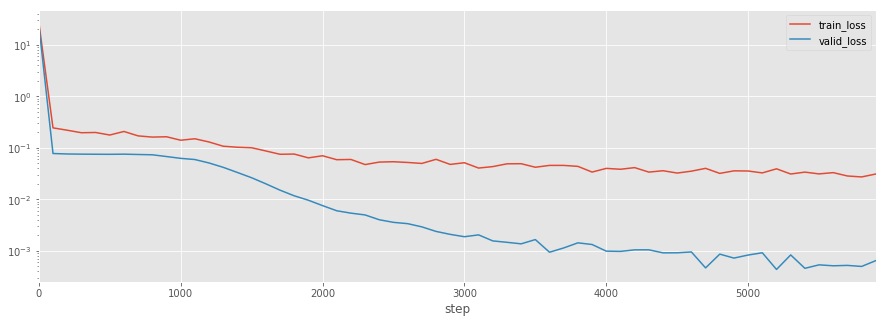

In [21]:
df_loss.set_index('step').plot(logy=True,figsize=(15,5))

# Your Turn  

> I reduced the number of neurons but increased the number of hidden layers. Try different combinations of layers and neurons and see how your model behaves.